Reference shape (h×w): (244, 360)
User shape      (h×w): (1655, 2738)


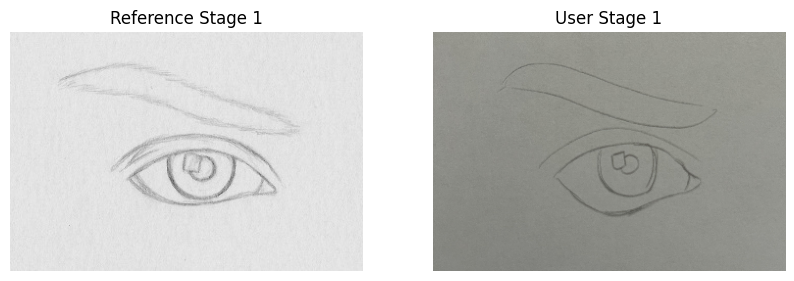

Reference shape (h×w): (246, 359)
User shape      (h×w): (1394, 2424)


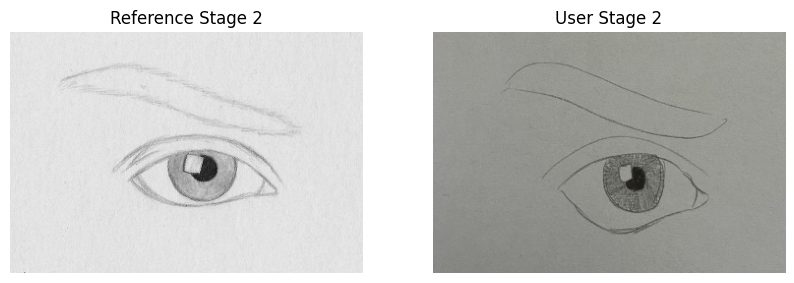

In [89]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

for i in range(1, 3):
    # 1. Load reference-stage image (Stage 1 of Artwork1)
    ref_path = f"../data/reference_stages/how-to-draw-eyes-step-{i}.jpg"
    ref_img = np.array(Image.open(ref_path).convert("RGB"))

    # 2. Load “user” progress image for Stage 1
    user_path = f"../data/user_samples/stage{i}.jpg"
    user_img = np.array(Image.open(user_path).convert("RGB"))

    print("Reference shape (h×w):", ref_img.shape[:2])
    print("User shape      (h×w):", user_img.shape[:2])

    # 3. Optionally, resize user image to exactly match reference shape (if they differ).
    ref_h, ref_w = ref_img.shape[:2]
    user_img = cv2.resize(user_img, (ref_w, ref_h))


    # 4. Show side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(ref_img)
    axs[0].set_title(f"Reference Stage {i}")
    axs[0].axis("off")
    axs[1].imshow(user_img)
    axs[1].set_title(f"User Stage {i}")
    axs[1].axis("off")
    plt.show()


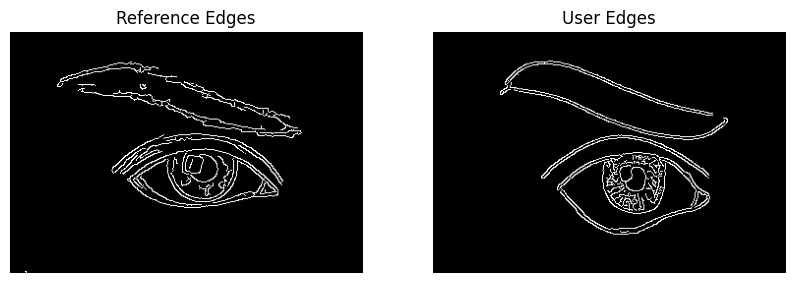

In [90]:
# 4.1 Convert to grayscale
ref_gray = cv2.cvtColor(ref_img, cv2.COLOR_RGB2GRAY)
user_gray = cv2.cvtColor(user_img, cv2.COLOR_RGB2GRAY)

# 4.2 Apply Gaussian blur (optional but helps reduce noise)
ref_blur = cv2.GaussianBlur(ref_gray, (5, 5), 0)
user_blur = cv2.GaussianBlur(user_gray, (5, 5), 0)

# 4.3 Run Canny edge detection
edges_ref = cv2.Canny(ref_blur, threshold1=20, threshold2=60)
edges_user = cv2.Canny(user_blur, threshold1=10, threshold2=50)

# 4.4 Visualize the raw edge maps
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(edges_ref, cmap="gray")
axs[0].set_title("Reference Edges")
axs[0].axis("off")
axs[1].imshow(edges_user, cmap="gray")
axs[1].set_title("User Edges")
axs[1].axis("off")
plt.show()


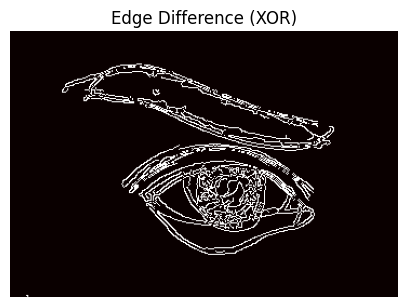

False

In [91]:
# 4.5 Binary maps: convert edges to 0/1
ref_bin = (edges_ref > 0).astype(np.uint8)
user_bin = (edges_user > 0).astype(np.uint8)

# 4.6 Pixel-wise XOR (1 where they differ)
diff_map = cv2.bitwise_xor(ref_bin, user_bin)

# 4.7 Visualize the difference map
plt.figure(figsize=(5, 5))
plt.imshow(diff_map, cmap="hot")
plt.title("Edge Difference (XOR)")
plt.axis("off")
plt.show()

# 4.8 (Optional) Save to disk for inspection
cv2.imwrite("../outputs/edges/diff_stage1.png", diff_map * 255)


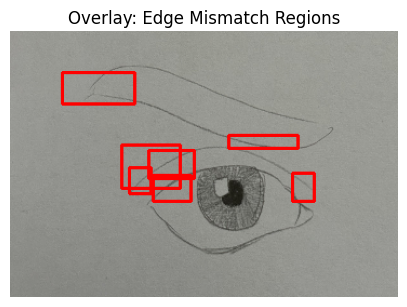

False

In [92]:
# 4.9 Find contours of difference regions
# kernel = np.ones((1, 2), np.uint8)
# diff_clean = cv2.morphologyEx(diff_map, cv2.MORPH_CLOSE, kernel, iterations=2)
contours, _ = cv2.findContours(diff_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 4.10 Create a blank RGB copy of user image to draw rectangles on
user_overlay = user_img.copy()
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    # Filter out tiny noise boxes
    if 2500 > w * h > 200:  # e.g., only keep boxes bigger than 50 px^2
        cv2.rectangle(user_overlay, (x, y), (x + w, y + h), color=(255, 0, 0), thickness=2)

# 4.11 Show overlay on user image
plt.figure(figsize=(5, 5))
plt.imshow(user_overlay)
plt.title("Overlay: Edge Mismatch Regions")
plt.axis("off")
plt.show()

# 4.12 Save that overlay for reference
cv2.imwrite("../outputs/edges/overlay_stage1.png", cv2.cvtColor(user_overlay, cv2.COLOR_RGB2BGR))


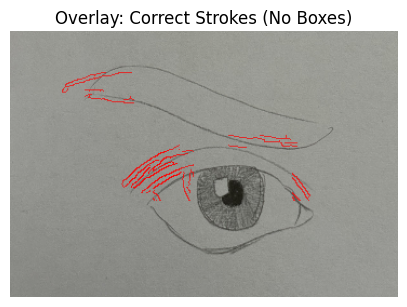

False

In [93]:
# Step 4.9: Already done — we have contours
# Create a color version of the user image to overlay strokes
user_overlay = user_img.copy()

# Convert reference edge map to 3-channel color image for color overlay
edges_ref_color = cv2.cvtColor(edges_ref, cv2.COLOR_GRAY2BGR)

# Color to overlay (e.g. red reference stroke)
stroke_color = (255, 0, 0)  # Blue in BGR
alpha = 0.7  # Transparency factor

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if 2500 > w * h > 200:
        # Get the edge patch from the reference
        stroke_patch = edges_ref_color[y:y+h, x:x+w]

        # Resize or threshold if necessary (optional)
        # Convert all white edges to stroke_color
        mask = cv2.cvtColor(stroke_patch, cv2.COLOR_BGR2GRAY)
        mask = mask > 0

        # Create a color mask of same size with stroke_color
        color_mask = np.zeros_like(stroke_patch)
        color_mask[mask] = stroke_color

        # Blend onto user_overlay in the same region
        roi = user_overlay[y:y+h, x:x+w]
        blended = np.where(mask[..., None], 
                           (alpha * color_mask + (1 - alpha) * roi).astype(np.uint8),
                           roi)
        user_overlay[y:y+h, x:x+w] = blended

# Show and save
plt.figure(figsize=(5, 5))
plt.imshow(user_overlay)
plt.title("Overlay: Correct Strokes (No Boxes)")
plt.axis("off")
plt.show()

cv2.imwrite("../outputs/edges/overlay_corrected_stage1.png", cv2.cvtColor(user_overlay, cv2.COLOR_RGB2BGR))


##VALUE COMPARISON

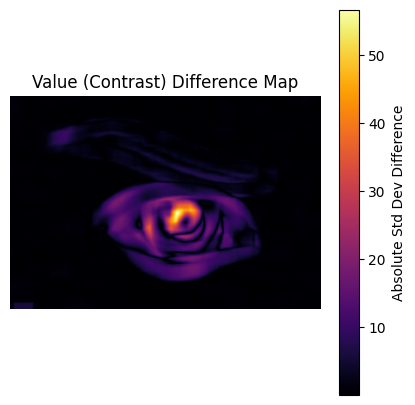

False

In [94]:
# 5.1 We already have grayscale images: ref_gray, user_gray

# 5.2 Compute local contrast maps.
# We'll do a sliding 16×16 window, compute standard deviation in each window.
def compute_local_contrast(gray_img, window_size=16):
    h, w = gray_img.shape
    contrast_map = np.zeros((h, w), dtype=np.float32)
    pad = window_size // 2

    # Pad with reflect so edges are handled
    padded = cv2.copyMakeBorder(gray_img, pad, pad, pad, pad, cv2.BORDER_REFLECT)
    for y in range(h):
        for x in range(w):
            patch = padded[y : y + window_size, x : x + window_size]
            contrast_map[y, x] = patch.std()
    return contrast_map

# Note: For speed, you can reduce the resolution (e.g. resize to 256×256) for testing.
ref_contrast = compute_local_contrast(cv2.resize(ref_gray, (256, 256)), window_size=16)
user_contrast = compute_local_contrast(cv2.resize(user_gray, (256, 256)), window_size=16)

# 5.3 Resize back to original size if needed
ref_contrast = cv2.resize(ref_contrast, (ref_w, ref_h))
user_contrast = cv2.resize(user_contrast, (ref_w, ref_h))

# 5.4 Compute absolute difference
contrast_diff = np.abs(ref_contrast - user_contrast)

# 5.5 Threshold the difference to highlight big shading errors
# e.g., any pixel where difference > 20 (on a 0–255 scale)
thresh = 20.0
shading_errors = (contrast_diff > thresh).astype(np.uint8)

# 5.6 Visualize the difference heatmap
plt.figure(figsize=(5, 5))
plt.imshow(contrast_diff, cmap="inferno")
plt.title("Value (Contrast) Difference Map")
plt.colorbar(label="Absolute Std Dev Difference")
plt.axis("off")
plt.show()

# 5.7 Save heatmap & binary error mask
cv2.imwrite("../outputs/value_diff/contrast_diff_stage1.png", (contrast_diff / contrast_diff.max() * 255).astype(np.uint8))
cv2.imwrite("../outputs/value_diff/shading_errors_stage1.png", shading_errors * 255)


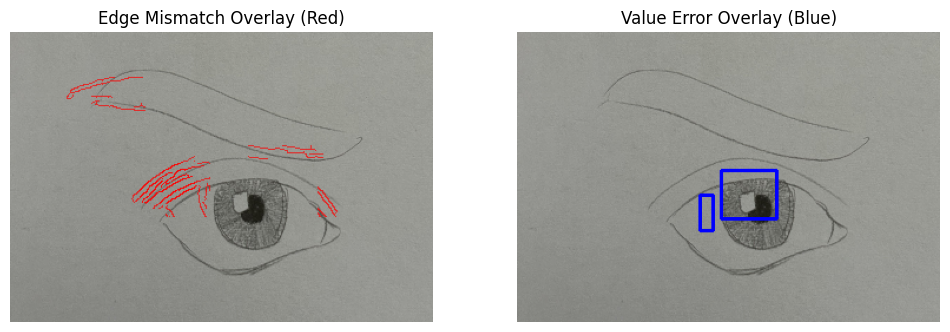

False

In [95]:
# 5.8 Find contours in shading_errors mask
contours_val, _ = cv2.findContours(shading_errors, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

# 5.9 Overlay boxes on user image
user_overlay_val = user_img.copy()
for cnt in contours_val:
    x, y, w, h = cv2.boundingRect(cnt)
    if w*h > 100:  # tune this threshold to filter tiny noise
        cv2.rectangle(user_overlay_val, (x, y), (x + w, y + h), color=(0, 0, 255), thickness=2)

# 5.10 Show combined overlays (edge & value) side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(user_overlay)  # from Step 4 – edge mismatch overlay
axs[0].set_title("Edge Mismatch Overlay (Red)")
axs[0].axis("off")
axs[1].imshow(user_overlay_val)
axs[1].set_title("Value Error Overlay (Blue)")
axs[1].axis("off")
plt.show()

# 5.11 Save this combined view to outputs
cv2.imwrite("../outputs/value_diff/overlay_value_stage1.png", cv2.cvtColor(user_overlay_val, cv2.COLOR_RGB2BGR))


##DOTS

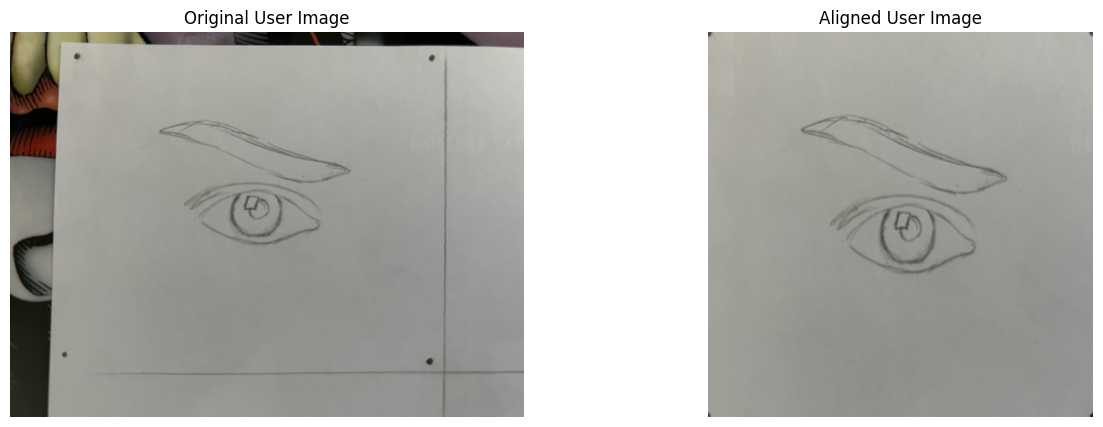

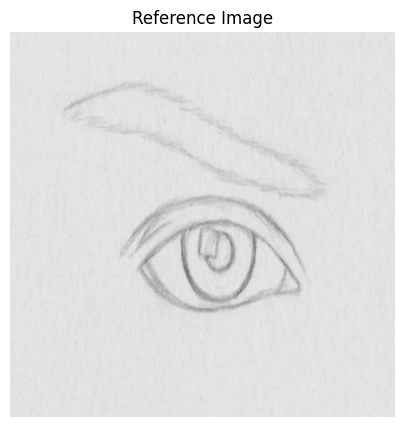

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
ref_path = "../data/reference_stages/how-to-draw-eyes-step-1.jpg"  # Replace with your path
user_path = "../data/user_samples/dots.jpg"  # Replace with your path

ref_img = cv2.imread(ref_path)
user_img = cv2.imread(user_path)

# Resize reference to a target size (you can adjust as needed)
target_size = (800, 800)
ref_img = cv2.resize(ref_img, target_size)

# Convert user image to grayscale for circle detection
gray = cv2.cvtColor(user_img, cv2.COLOR_BGR2GRAY)
gray = cv2.medianBlur(gray, 5)

# Detect circles using Hough Transform
circles = cv2.HoughCircles(
    gray,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=gray.shape[0] // 5,
    param1=50,
    param2=30,
    minRadius=5,
    maxRadius=30
)

if circles is None or len(circles[0]) < 4:
    raise ValueError("Could not find 4 corner dots. Please retake the photo with clearer corner dots.")

# Round and sort circles
circles = np.round(circles[0]).astype("int")
dots = sorted(circles[:4], key=lambda c: (c[1], c[0]))  # sort by y, then x

# Sort into consistent corner order
def sort_corners(pts):
    pts = np.array(pts, dtype="float32")
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)
    return np.array([
        pts[np.argmin(s)],      # top-left
        pts[np.argmin(diff)],   # top-right
        pts[np.argmax(s)],      # bottom-right
        pts[np.argmax(diff)]    # bottom-left
    ], dtype="float32")

user_pts = sort_corners([(x, y) for x, y, _ in dots])
ref_pts = np.array([
    [0, 0],
    [target_size[0] - 1, 0],
    [target_size[0] - 1, target_size[1] - 1],
    [0, target_size[1] - 1]
], dtype="float32")

# Perspective transform
matrix = cv2.getPerspectiveTransform(user_pts, ref_pts)
aligned_user = cv2.warpPerspective(user_img, matrix, target_size)

# Show result
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(user_img, cv2.COLOR_BGR2RGB))
plt.title("Original User Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(aligned_user, cv2.COLOR_BGR2RGB))
plt.title("Aligned User Image")
plt.axis("off")
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB))
plt.title("Reference Image")
plt.axis("off")
plt.show()
